# Running the system through qiskit-cold-atom

In this section, we will show how to run the system through the [qiskit-cold-atom](https://github.com/Qiskit-Extensions/qiskit-cold-atom) package. We will start with a short introduction to the package module and then show how to access `qlued` through the package.

## Introduction to qiskit-cold-atom

[qiskit-cold-atom](https://github.com/Qiskit-Extensions/qiskit-cold-atom) is an extension to the popular [Qiskit](https://qiskit.org/) framework. It is designed to simulate quantum circuits on cold atom devices. To provides access to local simulators and remote quantum hardware including providers such as `qlued`. To access `qlued` based systems, you should first install `qiskit-cold-atoms` locally:

```bash
pip install git+https://github.com/Qiskit-Extensions/qiskit-cold-atom.git
```

This installs the most up-to-date version of the package, which is compatible with our current API.  To run the cells in the repo, you'll need to have a registered account with a valid username and token for this provider. You can obtain such credentials by visiting the [sign-up page](https://qlued.alqor.io/accounts/login/).

## Accessing qlued through qiskit-cold-atom

The following is based on the tutorial, which is also directly published [here](https://github.com/Qiskit-Extensions/qiskit-cold-atom/blob/main/docs/tutorials/09_ryberg_dynamics.ipynb) in the original repo. Here, we simply focus on the necessary steps to access `qlued` through the package.

In [12]:
from pprint import pprint

import numpy as np
import matplotlib.pyplot as plt
from qiskit.circuit import QuantumCircuit, Parameter
from qiskit_cold_atom.providers import ColdAtomProvider

Saving/enabling your backend credentials (Optional if not alreayd done).

In [2]:
provider = ColdAtomProvider.save_account(
    url=[
        "https://qlued.alqor.io/api/v2/singlequdit",
        "https://qlued.alqor.io/api/v2/multiqudit",
        "https://qlued.alqor.io/api/v2/fermions",
        "https://qlued.alqor.io/api/v2/rydberg",
    ],
    username="NAME",
    token="TOKEN",
    overwrite=True
)

We can now load the necessary backend

In [3]:
provider = ColdAtomProvider.load_account()

spin_device_backend = provider.get_backend("alqor_rydberg_simulator")
pprint(spin_device_backend.configuration().supported_instructions)

['rlx', 'rlz', 'rydberg_block', 'rydberg_full', 'barrier', 'measure']


As you can see from above the simulator backend does provide the necessary gates. The nice thing about qiskit-cold-atom is that it provides a straight-forward way to define a circuit. It basically nicely wraps around all the json and makes accessible in a more "common" fashion.

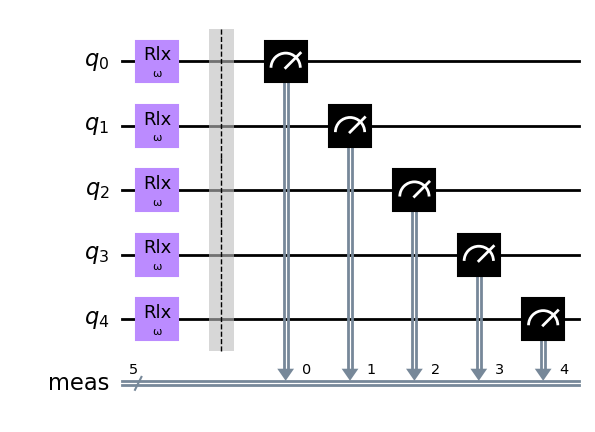

In [4]:
# define the number of wires
Nwires = 5

# define the parameter which we will sweep over
omega_t = Parameter("ω")

# define the quantum circuit object
qc_rabi = QuantumCircuit(5)

all_modes=range(Nwires)

# apply the time-dependent rotation to all the wires
qc_rabi.rlx( omega_t, all_modes)

# measure all the wires
qc_rabi.measure_all()

# draw the circuit
qc_rabi.draw(output='mpl')

Now that we have created the circuit we can execute it in the same way as in the all the other tutorials. But once again, all wrapped up in a nice way.

In [6]:
phases = np.linspace(0, 2*np.pi,15)

# create a list of circuits with different phases
remote_rabi_list = [
    qc_rabi.assign_parameters(
        {omega_t: phase},
        inplace=False,
    )
    for phase in phases
]

# send the job to the backend
job_remote_rabi = spin_device_backend.run(remote_rabi_list, shots=500)

The resulting job object can be used to retrieve the results of the simulation. Let us first obtain the `job_id`

In [7]:
job_remote_rabi.job_id()

'8780f5ec7eb2426686563b56'

Now, we can have a look if the job is finished in the standard `qiskit` way.

In [8]:
job_rabi_retrieved = spin_device_backend.retrieve_job(job_id=job_remote_rabi.job_id())

print("job status: ", job_rabi_retrieved.status())

job status:  JobStatus.DONE


Finally, we can retrieve the results of the simulation.

In [9]:
result_remote_rabi = job_rabi_retrieved.result()

Before we can plot the results, we need to convert the results into a more convenient format. 

In [10]:
outcomes = [result_remote_rabi.get_memory(i) for i in range(len(remote_rabi_list))]
for i, outcome in enumerate(outcomes):
    for j, run in enumerate(outcome):
        outcomes[i][j] = np.array(run.split(' '), dtype = int)
        
outcomes = np.array(outcomes)
means_remote_rabi = outcomes.mean(axis=1)

And finally, we can plot the results.

Text(0.5, 0, 'time')

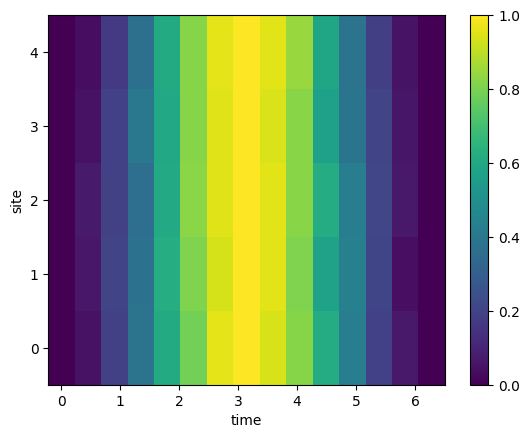

In [13]:
f, ax = plt.subplots()
im = ax.pcolormesh(phases,np.arange(5), means_remote_rabi.T)
f.colorbar(im, ax=ax)

ax.set_ylabel('site')
ax.set_xlabel('time')

### Blockade on a remote system

In this last step, we can execute the Ryberg blockade on the remote system to observe the appearance of the alternating spin structure.

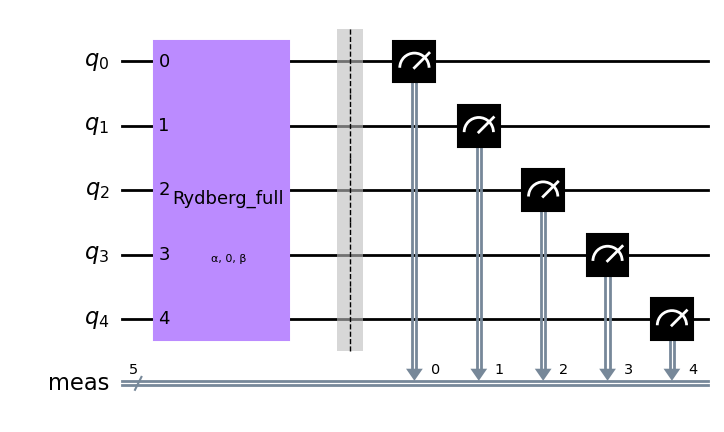

In [14]:
Nwires = 5
qc2 = QuantumCircuit(5)

all_modes=range(Nwires)
alpha = Parameter("α")
beta = Parameter("β")

qc2.rydberg_full(omega = alpha, delta =0, phi = beta, modes=all_modes)

qc2.measure_all()
qc2.draw(output='mpl')

In [15]:
phases = np.linspace(0, 2*np.pi,15)

circuit2_list = [
    qc2.assign_parameters(
        {alpha: phase, beta: phase*2},
        inplace=False,
    )
    for phase in phases
]

In [16]:
job2 = spin_device_backend.run(circuit2_list, shots=500)

In [17]:
job2.job_id()

'24b401a735db404f9110d27a'

In [18]:
job_retrieved2 = spin_device_backend.retrieve_job(job_id=job2.job_id())

print("job status: ", job_retrieved2.status())

job status:  JobStatus.DONE


In [19]:
result2 = job_retrieved2.result()

make this a card of averages

In [20]:
outcomes = [result2.get_memory(i) for i in range(len(circuit2_list))]
for i, outcome in enumerate(outcomes):
    for j, run in enumerate(outcome):
        outcomes[i][j] = np.array(run.split(' '), dtype = int)
outcomes = np.array(outcomes)

In [21]:
means_1 = outcomes.mean(axis=1)

Text(0.5, 0, 'time')

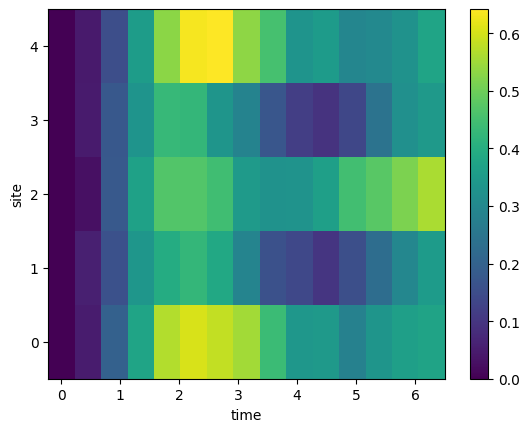

In [22]:
f, ax = plt.subplots()
im = ax.pcolormesh(phases,np.arange(5), means_1.T)
f.colorbar(im, ax=ax)

ax.set_ylabel('site')
ax.set_xlabel('time')

In [39]:
import qiskit.tools.jupyter

%qiskit_version_table